In [1]:
%matplotlib inline
import re
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from elasticsearch import Elasticsearch, exceptions as es_exceptions
from elasticsearch.helpers import scan
es = Elasticsearch(hosts=[{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)

# To list all indices, do 
# curl -XGET 'http://atlas-kibana.mwt2.org:9200/_settings?pretty=1' 
ind="jobs_archive_2016*"

In [2]:
# one can also use the following command to see the return json data.
# curl -XGET 'http://atlas-kibana.mwt2.org:9200/jobs_archive_2016*/_search?pretty=1&size=1'

x = {
    "fields": ["wall_time","modificationtime","modificationhost","computingsite"],
    "query": {
        "bool": {
            "must": [{ "match": { "computingsite": "ANALY_SLAC" }},
                     { "wildcard": { "modificationhost": "fell*" }},
                     { "match": { "jobstatus": "finished" }}, 
                     { "match": { "transfertype": "fax"}} ]
        }
    }
}

walltimes0 = []
walltimes1 = []
# period the NAT was set on the fells:
timerange0 = datetime.strptime("2016-01-11","%Y-%m-%d")
timerange1 = datetime.strptime("2016-04-05","%Y-%m-%d")

page = es.search(index=ind, body=x, search_type="scan", scroll="1m", size=1000)
scroll_size = page['hits']['total']

while (scroll_size > 0):
    try:
        sid = page['_scroll_id']
        page = es.scroll(scroll_id = sid, scroll = '1m')
        scroll_size = len(page['hits']['hits'])
        for job in page['hits']['hits']:
            #print(job)
            #hostname = job['fields']['modificationhost'][0]
            #if re.search("fell",hostname) is None:
            #    continue
            hostnumb = int(re.sub("fell","",hostname))
            timestamp = datetime.strptime(job['fields']['modificationtime'][0],"%Y-%m-%dT%H:%M:%S")
            if (timestamp<timerange0 or timestamp>timerange1):
                continue                               
            wallt = job['fields']['wall_time'][0]/60
            #print ("hostname: %s, walltime: %.2f" % (hostn, wallt))
            if (wallt<10 or wallt>360):
                continue
            if hostnumb < 140:
                walltimes0 += [wallt]
            else:
                walltimes1 += [wallt]
    except:
        break


0 0


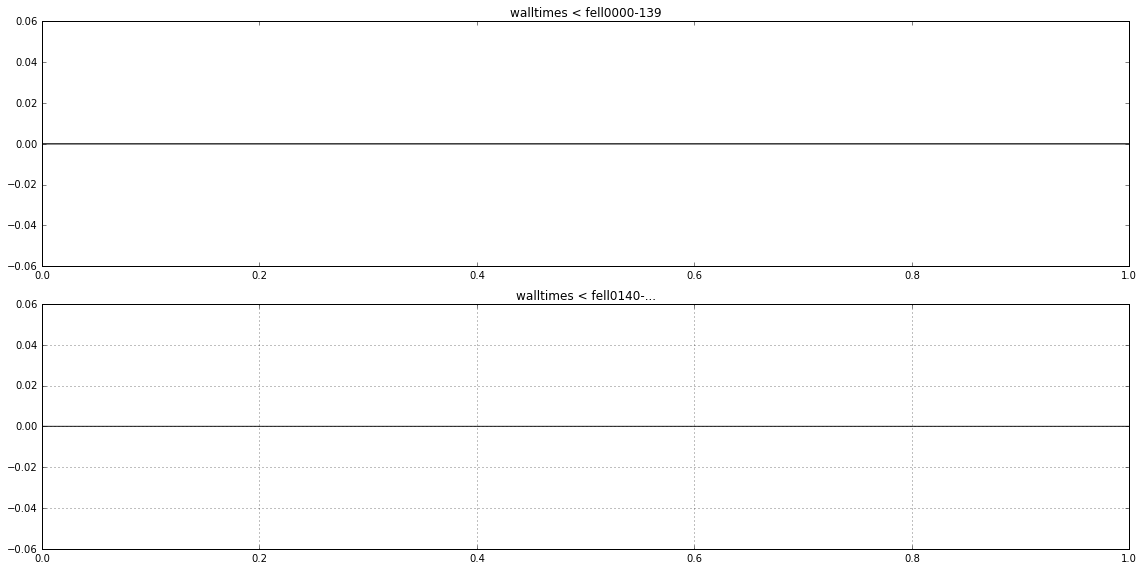

In [3]:
print("%d %d" % (len(walltimes0), len(walltimes1)))
fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(16, 8))
ax0.hist(walltimes0, 100, histtype='stepfilled', facecolor='g', alpha=0.75)
ax0.set_title('walltimes < fell0000-139')
ax1.hist(walltimes1, 100, histtype='stepfilled', facecolor='r', alpha=0.75)
ax1.set_title('walltimes < fell0140-...')
plt.tight_layout()
plt.grid(True)
plt.show()